# ETS models

The ETS models are a family of time series models with an underlying state space model consisting of a level component, a trend component (T), a seasonal component (S), and an error term (E).

This notebook gives a very brief introduction to these models and shows how they can be used with statsmodels. For a more thorough treatment we refer to [1], chapter 8 (free online resource), on which the implementation in statsmodels and the examples used in this notebook are based.

[1] Hyndman, Rob J., and George Athanasopoulos. *Forecasting: principles and practice*, 3rd edition, OTexts, 2019. https://www.otexts.org/fpp3/7

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

ModuleNotFoundError: No module named 'statsmodels.tsa.exponential_smoothing._ets_smooth'

In [6]:
plt.rcParams['figure.figsize'] = (12, 8)

## Simple exponential smoothing

The simplest of the ETS models is also known as *simple exponential smoothing*. In ETS terms, it corresponds to the (A, N, N) model, that is, a model with additive errors, no trend, and no seasonality. The state space formulation of Holt's method is:

\begin{align}
y_{t} &= y_{t-1} + e_t\\
l_{t} &= l_{t-1} + \alpha e_t\\
\end{align}

This state space formulation can be turned into a different formulation, a forecast and a smoothing equation (as can be done with all ETS models):

\begin{align}
\hat{y}_{t|t-1} &= l_{t-1}\\
l_{t} &= \alpha y_{t-1} + (1 - \alpha) l_{t-1}
\end{align}

Here, $\hat{y}_{t|t-1}$ is the forecast/expectation of $y_t$ given the information of the previous step. In the simple exponential smoothing model, the forecast corresponds to the previous level. The second equation (smoothing equation) calculates the next level as weighted average of the previous level and the previous observation.

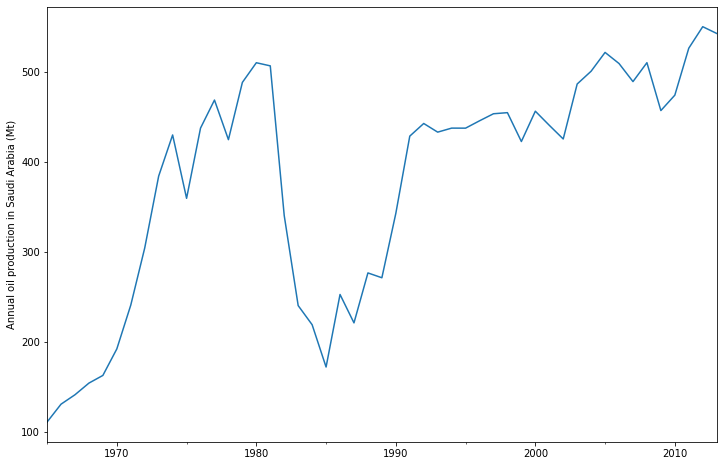

In [7]:
oildata = [
    111.0091, 130.8284, 141.2871, 154.2278,
    162.7409, 192.1665, 240.7997, 304.2174,
    384.0046, 429.6622, 359.3169, 437.2519,
    468.4008, 424.4353, 487.9794, 509.8284,
    506.3473, 340.1842, 240.2589, 219.0328,
    172.0747, 252.5901, 221.0711, 276.5188,
    271.1480, 342.6186, 428.3558, 442.3946,
    432.7851, 437.2497, 437.2092, 445.3641,
    453.1950, 454.4096, 422.3789, 456.0371,
    440.3866, 425.1944, 486.2052, 500.4291,
    521.2759, 508.9476, 488.8889, 509.8706,
    456.7229, 473.8166, 525.9509, 549.8338,
    542.3405
]
oil = pd.Series(oildata, index=pd.date_range('1965', '2013', freq='AS'))
oil.plot()
plt.ylabel("Annual oil production in Saudi Arabia (Mt)");

The plot above shows annual oil production in Saudia Arabia in million tonnes. The data are taken from the R package `fpp2` (companion package to prior version [1]).
Below you can see how to fit a simple exponential smoothing model using statsmodel's ETS implementation to this data. Additionally, the fit using `forecast` in R is shown as comparison.

In [8]:
model = ETSModel(oil, error='add', trend='add', damped_trend=True)
fit = model.fit(maxiter=10000)
oil.plot(label='data')
fit.fittedvalues.plot(label='statsmodels fit')
plt.ylabel("Annual oil production in Saudi Arabia (Mt)");

# obtained from R
params_R = [0.99989969, 0.11888177503085334, 0.80000197, 36.46466837, 34.72584983]
yhat = model.smooth(params_R).fittedvalues
yhat.plot(label='R fit', linestyle='--')

plt.legend();

NameError: name 'ETSModel' is not defined

By default the initial states are considered to be fitting parameters and are estimated by maximizing log-likelihood. Additionally it is possible to only use a heuristic for the initial values. In this case this leads to better agreement with the R implementation.

In [9]:
model_heuristic = ETSModel(oil, error='add', trend='add', damped_trend=True,
                          initialization_method='heuristic')
fit_heuristic = model_heuristic.fit()
oil.plot(label='data')
fit.fittedvalues.plot(label='estimated')
fit_heuristic.fittedvalues.plot(label='heuristic', linestyle='--')
plt.ylabel("Annual oil production in Saudi Arabia (Mt)");

# obtained from R
params = [0.99989969, 0.11888177503085334, 0.80000197, 36.46466837, 34.72584983]
yhat = model.smooth(params).fittedvalues
yhat.plot(label='with R params', linestyle=':')

plt.legend();

NameError: name 'ETSModel' is not defined

In [10]:
fit.summary()

NameError: name 'fit' is not defined

In [ ]:
fit_heuristic.summary()

## Holt-Winters' seasonal method

The exponential smoothing method can be modified to incorporate a trend and a seasonal component. In the additive Holt-Winters' method, the seasonal component is added to the rest. This model corresponds to the ETS(A, A, A) model, and has the following state space formulation:

\begin{align}
y_t &= l_{t-1} + b_{t-1} + s_{t-m} + e_t\\
l_{t} &= l_{t-1} + b_{t-1} + \alpha e_t\\
b_{t} &= b_{t-1} + \beta e_t\\
s_{t} &= s_{t-m} + \gamma e_t
\end{align}



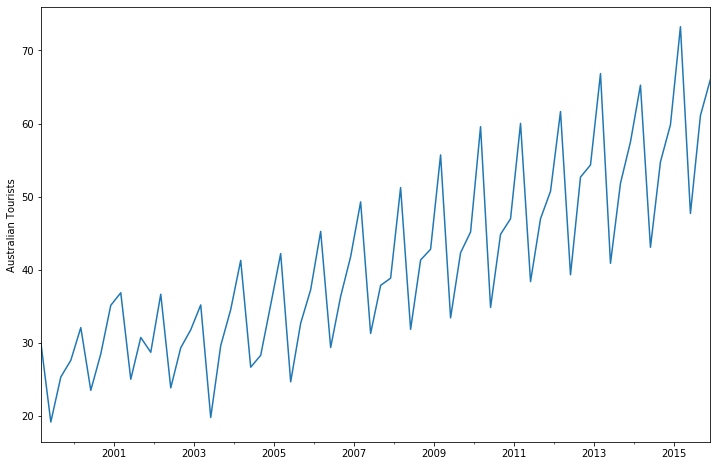

In [11]:
austourists_data = [
    30.05251300, 19.14849600, 25.31769200, 27.59143700,
    32.07645600, 23.48796100, 28.47594000, 35.12375300, 
    36.83848500, 25.00701700, 30.72223000, 28.69375900, 
    36.64098600, 23.82460900, 29.31168300, 31.77030900,
    35.17787700, 19.77524400, 29.60175000, 34.53884200,
    41.27359900, 26.65586200, 28.27985900, 35.19115300,
    42.20566386, 24.64917133, 32.66733514, 37.25735401,
    45.24246027, 29.35048127, 36.34420728, 41.78208136,
    49.27659843, 31.27540139, 37.85062549, 38.83704413,
    51.23690034, 31.83855162, 41.32342126, 42.79900337,
    55.70835836, 33.40714492, 42.31663797, 45.15712257,
    59.57607996, 34.83733016, 44.84168072, 46.97124960,
    60.01903094, 38.37117851, 46.97586413, 50.73379646,
    61.64687319, 39.29956937, 52.67120908, 54.33231689,
    66.83435838, 40.87118847, 51.82853579, 57.49190993,
    65.25146985, 43.06120822, 54.76075713, 59.83447494,
    73.25702747, 47.69662373, 61.09776802, 66.05576122,
]
index = pd.date_range("1999-03-01", "2015-12-01", freq="3MS")
austourists = pd.Series(austourists_data, index=index)
austourists.plot()
plt.ylabel('Australian Tourists');

In [12]:
# fit in statsmodels
model = ETSModel(austourists, error="add", trend="add", seasonal="add",
                damped_trend=True, seasonal_periods=4)
fit = model.fit()

# fit with R params
params_R = [
    0.35445427, 0.03200749, 0.39993387, 0.97999997, 24.01278357, 
    0.97770147, 1.76951063, -0.50735902, -6.61171798, 5.34956637
]
fit_R = model.smooth(params_R)

austourists.plot(label='data')
plt.ylabel('Australian Tourists')

fit.fittedvalues.plot(label='statsmodels fit')
fit_R.fittedvalues.plot(label='R fit', linestyle='--')
plt.legend();

NameError: name 'ETSModel' is not defined

In [13]:
fit.summary()

NameError: name 'fit' is not defined

In [14]:
fit._rank

NameError: name 'fit' is not defined